In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import functools

In [2]:
image_path  = "./images/license17.jpg"

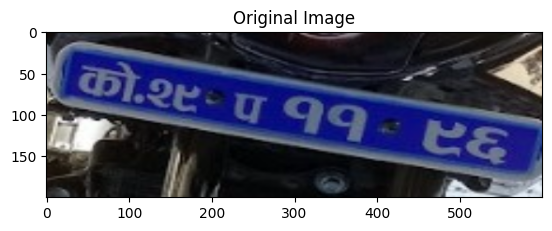

In [3]:

image = cv2.imread(image_path)
image = cv2.resize(image, (600,200))
plt.imshow(image)
plt.title('Original Image')
original_image = image.copy()
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
# image to segment will be in final_original_image below

Text(0.5, 1.0, 'Original Image RGB')

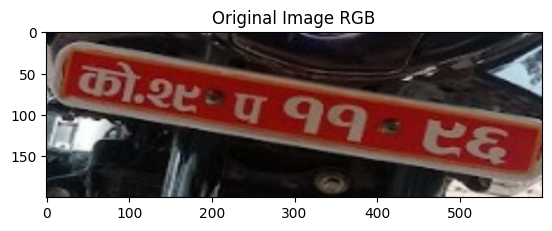

In [4]:
plt.imshow(original_image)
plt.title('Original Image RGB')

Text(0.5, 1.0, 'HSV Image')

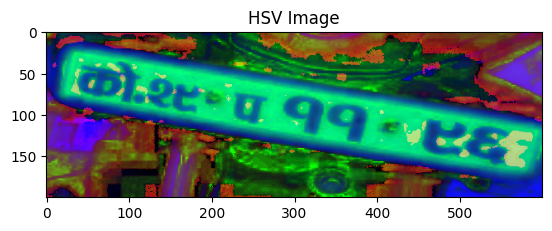

In [5]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_image)
plt.title('HSV Image')

Text(0.5, 1.0, 'Equalized Image')

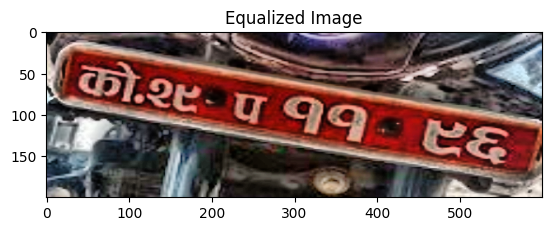

In [6]:
h,s,v = cv2.split(hsv_image)

# clahe equalization on hsv
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
equalized_v = clahe.apply(v)
merged_hsv = cv2.merge([h,s,equalized_v])
equalized_bgr = cv2.cvtColor(merged_hsv, cv2.COLOR_HSV2BGR)
plt.imshow(cv2.cvtColor(equalized_bgr, cv2.COLOR_BGR2RGB))
plt.title('Equalized Image')


Text(0.5, 1.0, 'Black Mask')

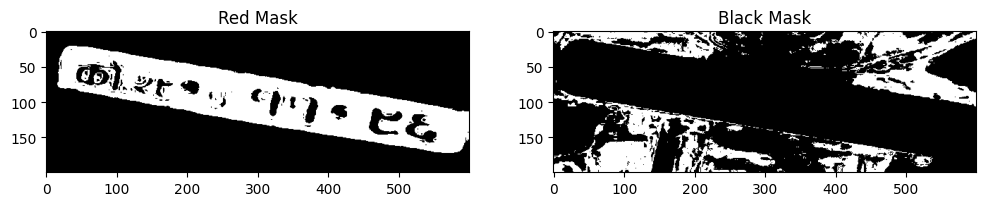

In [7]:
# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 100, 100])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160,100,100])
upper2 = np.array([179,255,255])

mask1 = cv2.inRange(hsv_image, lower1, upper1)
mask2 = cv2.inRange(hsv_image, lower2, upper2)

red_mask = cv2.bitwise_or(mask1, mask2)

# Define lower and upper bounds for black color in HSV
# For black colors in HSV  hue at maximum range (0 to 180), and saturation at maximum range (0 to 255) can play with the value 0 to 30 or 50 for black
# if the image has very light black color then increase the value to 100 or less than 120
lower_black = np.array([0, 0, 0])
upper_black = np.array([180, 60, 60])

# Create a mask for black color
mask_black = cv2.inRange(hsv_image, lower_black, upper_black)

multi_color_mask = cv2.bitwise_or(red_mask, mask_black)

plt.figure(figsize=(12, 6))  # Set the figure size to large

plt.subplot(1, 2, 1)
plt.imshow(red_mask, cmap='gray')
plt.title('Red Mask')

plt.subplot(1, 2, 2)
plt.imshow(mask_black, cmap='gray')
plt.title("Black Mask")


Text(0.5, 1.0, 'Masked Image')

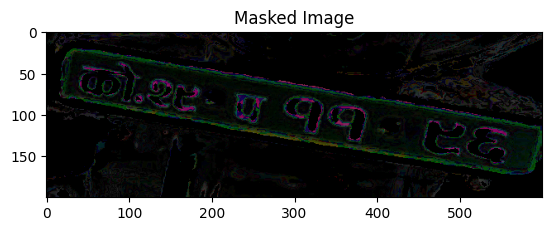

In [8]:

masked_image = cv2.bitwise_and(original_image, equalized_bgr, mask=multi_color_mask)
plt.imshow(masked_image)
plt.title('Masked Image')

In [9]:
def perspective_transform(image, pts):
    # Get the maximum width and height
    max_width = max(np.linalg.norm(pts[0] - pts[1]), np.linalg.norm(pts[2] - pts[3]))
    max_height = max(np.linalg.norm(pts[0] - pts[3]), np.linalg.norm(pts[1] - pts[2]))

    # Set destination points
    dst_pts = np.array([[0, 0], [max_width - 1, 0], [max_width - 1, max_height - 1], [0, max_height - 1]], dtype='float32')

    # Calculate perspective transform matrix
    matrix = cv2.getPerspectiveTransform(pts, dst_pts)

    # Apply perspective transform
    result = cv2.warpPerspective(image, matrix, (int(max_width), int(max_height)))

    return result


In [10]:
red_pixels = cv2.countNonZero(red_mask)
black_pixels = cv2.countNonZero(mask_black)

print(f"Red pixels: {red_pixels}")
print(f"Black pixels: {black_pixels}")

if red_pixels > black_pixels:
    dominant_color = 'red'
    dominant_mask = red_mask
else:
    dominant_color = 'black'
    dominant_mask = mask_black

contours, hierarchy = cv2.findContours(dominant_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Sort contours by area and get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate a minimum rectangle around the largest contour
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Convert box points to float32
    box = box.astype(np.float32)

    # Perform perspective transform
    transformed_image = perspective_transform(image, box)

if transformed_image.shape[0] > transformed_image.shape[1]:
    transformed_image = cv2.rotate(transformed_image, cv2.ROTATE_90_COUNTERCLOCKWISE)

resized_image = cv2.resize(transformed_image, (600, 200))



Red pixels: 32663
Black pixels: 27113


Text(0.5, 1.0, 'Transformed Image')

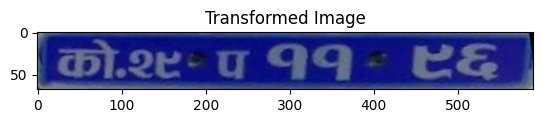

In [11]:
plt.imshow(transformed_image)
plt.title('Transformed Image')

Text(0.5, 1.0, 'Transformed and resized image')

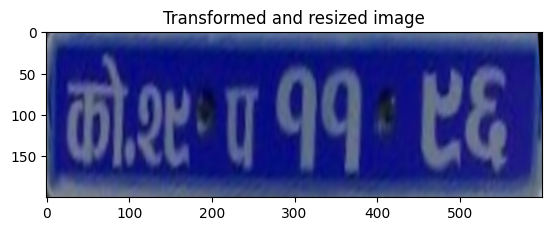

In [12]:
plt.imshow(resized_image)
plt.title("Transformed and resized image")

Text(0.5, 1.0, 'Final image')

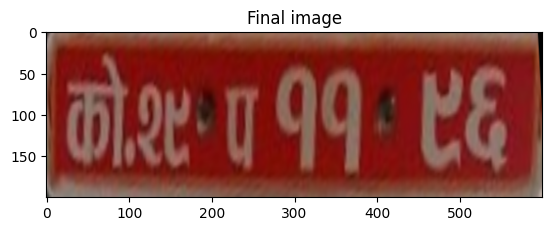

In [13]:
# saving the resized image
resized_image.shape
final_original_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
plt.imshow(final_original_image)
plt.title("Final image")

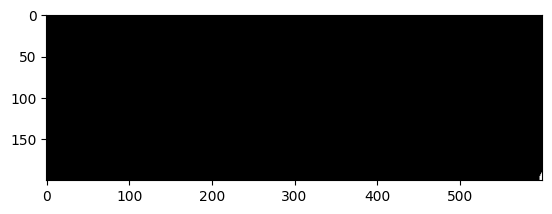

In [14]:
lower_white = np.array([0,150,150])
upper_white = np.array([255,255,255])

white_mask = cv2.inRange(final_original_image, lower_white, upper_white)
masked_image = cv2.bitwise_and(final_original_image, final_original_image, mask=white_mask)

test = cv2.bitwise_and(final_original_image,masked_image)

plt.imshow(white_mask,cmap="gray")


# send masked_white or final_original


Text(0.5, 1.0, 'Gray Image')

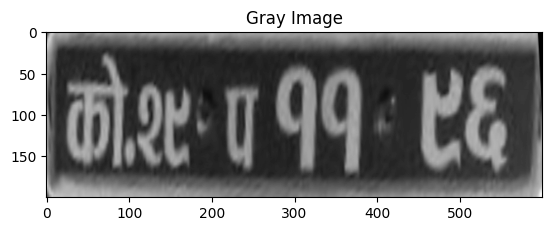

In [15]:
image_process = cv2.cvtColor(final_original_image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_process, cmap="gray")
plt.title('Gray Image')

In [16]:
# clahe histogram
# clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
# image_process_equalized = clahe.apply(image_process)
# plt.imshow(image_process_equalized, cmap="gray")

# adaptive histogram
# image_process_equalized = cv2.equalizeHist(image_process)
# plt.imshow(image_process_equalized, cmap="gray")

Text(0.5, 1.0, 'After blur')

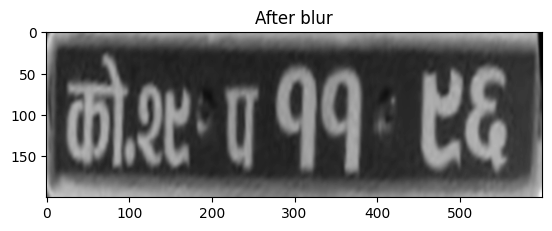

In [17]:
kernel = np.ones((5,5),dtype=np.uint8)
blurred_image = cv2.GaussianBlur(image_process, (5,5), 0)
plt.imshow(blurred_image, cmap="gray")
plt.title("After blur")

Text(0.5, 1.0, 'Histogram of process image')

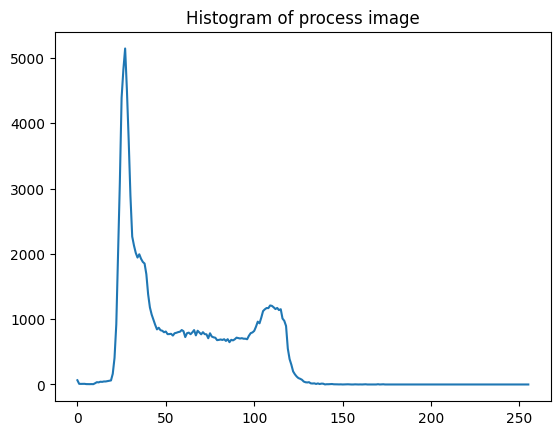

In [18]:
calc_process_hist = cv2.calcHist([blurred_image], [0], None, [256], [0, 256])
plt.plot(calc_process_hist)
plt.title("Histogram of process image")

Text(0.5, 1.0, 'Threshold image')

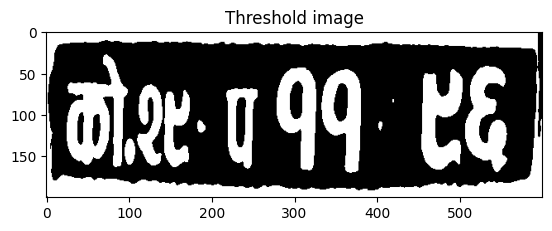

In [19]:
# thresh option 1
# ret, thresh = cv2.threshold(image_process,140,255,cv2.THRESH_BINARY)

# thresh option 2
ret, thresh = cv2.threshold(blurred_image,120,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')
plt.title("Threshold image")

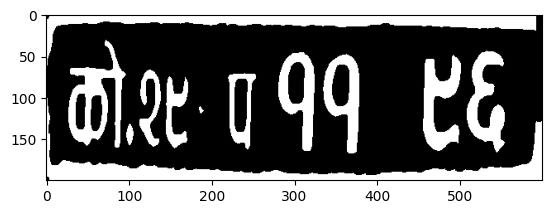

In [20]:
kernel = np.ones((5,5), np.uint8)

erode = cv2.erode(thresh, kernel, iterations=1)

plt.imshow(erode, cmap='gray')
# thresh = equalized_morphed

Text(0.5, 1.0, 'Image with Border')

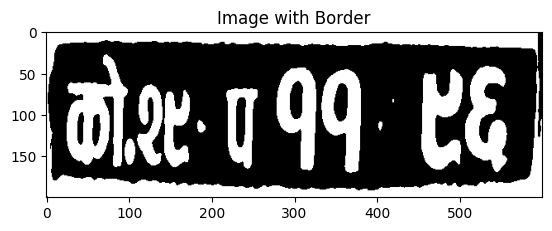

In [21]:
border_size = 10
border_color = (0, 0, 0)  # black color

# Add border to the image
# cv2.rectangle(thresh, (0, 0), (thresh.shape[1], thresh.shape[0]), border_color, border_size)

plt.imshow(thresh, cmap='gray')
plt.title('Image with Border')



In [22]:
_, labels = cv2.connectedComponents(thresh)
mask = np.zeros(thresh.shape, dtype="uint8")

In [23]:
total_pixels = image.shape[0] * image.shape[1]
lower = 300
upper = total_pixels * 0.2

In [24]:
# Loop over the unique components
for (i, label) in enumerate(np.unique(labels)):
    # label 0 vaneko background ho
    if label == 0:
        continue

    # otherwise construct the label mask to display only connected component
    # for the current label
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)

    # Get the bounding box of the connected component
    (y, x) = np.where(labels == label)
    (topY, topX) = (np.min(y), np.min(x))
    (bottomY, bottomX) = (np.max(y), np.max(x))
    width = bottomX - topX
    height = bottomY - topY


    # filtering the bounding box
    if width > 180 or height > 140:
        continue

    # filtering if the width and height is more than 100px but has less pixel values
    if width > 100 and height > 100 and numPixels < 2000:
        continue

    # more filtering
    if width > 20 and height > 20:
        # print(width, height, numPixels)
        if numPixels > lower and numPixels < upper:
            # Check if the line starts from the top and ends at more than half the height
            mask = cv2.add(mask, labelMask)
            print(topX, topY, bottomX, bottomY,width,height,numPixels)


25 28 98 163 73 135 5315
507 42 557 169 50 127 3735
279 44 326 167 47 123 3421
333 46 380 170 47 124 3400
454 46 503 166 49 120 3728
110 64 140 161 30 97 1795
218 69 255 165 37 96 2117
143 71 173 163 30 92 1799


Text(0.5, 1.0, 'After cleaning image')

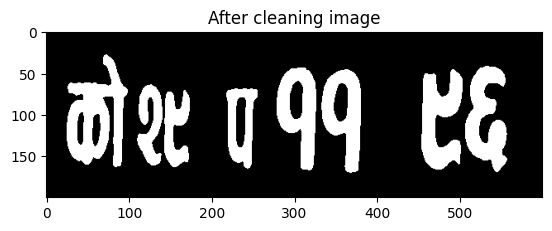

In [25]:
plt.imshow(mask,cmap='gray')
plt.title("After cleaning image")

In [26]:
# contours, hierarchy= cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# boundingBoxes = [cv2.boundingRect(c) for c in contours]
contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 1000]

print(boundingBoxes)

boundingBoxes = [bbox for bbox in boundingBoxes if bbox[2] / bbox[3] <= 3 and bbox[3] / bbox[2] <= 4]

for c in contours:
    print(cv2.contourArea(c))


[(143, 71, 31, 93), (218, 69, 38, 97), (110, 64, 31, 98), (454, 46, 50, 121), (333, 46, 48, 125), (279, 44, 48, 124), (507, 42, 51, 128), (25, 28, 74, 136)]
1660.5
2612.0
1647.0
3531.0
3878.5
3868.5
3536.5
5589.0


In [27]:
def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 30:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare) )
print(boundingBoxes)

[(25, 28, 74, 136), (110, 64, 31, 98), (143, 71, 31, 93), (218, 69, 38, 97), (279, 44, 48, 124), (333, 46, 48, 125), (454, 46, 50, 121), (507, 42, 51, 128)]


In [28]:
for i, bbox in enumerate(boundingBoxes):
    x, y, w, h = bbox
    if x > 10 and y > 10:
            padding = 10
    else:
            padding = 0
    padding = 0
    cropped_image = final_original_image[y-padding:y+h+padding, x-padding:x+w+padding]
    cropped_resized = cv2.resize(cropped_image, (64,64))
    cropped_resized = cv2.cvtColor(cropped_resized, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'./ch/character_{i}.png', cropped_resized)

True

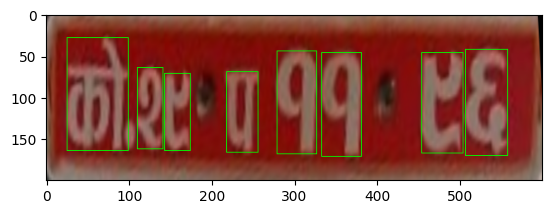

In [29]:
for bbox in boundingBoxes:
    x, y, w, h = bbox
    cv2.rectangle(final_original_image, (x, y), (x+w, y+h), (0, 255, 0), 1)
plt.imshow(final_original_image)
cv2.imwrite('final_image.jpg',final_original_image)